# Peut-on classer les sujets de la Fédération de Russie en fonction de leur type uniquement via un nombre limité de données démographiques?

url dataset:
https://www.kaggle.com/datasets/dwdkills/russian-demography

-------------------
---------------
-----------

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
dataset = pd.read_csv('russian_demography.csv') #Lecture du Dataset

In [3]:
dataset #Vue globale du dataset

,year,region,npg,birth_rate,death_rate,gdw,urbanization
0,1990,Republic of Adygea,1.9,14.2,12.3,84.66,52.42
1,1990,Altai Krai,1.8,12.9,11.1,80.24,58.07
2,1990,Amur Oblast,7.6,16.2,8.6,69.55,68.37
3,1990,Arkhangelsk Oblast,3.7,13.5,9.8,73.26,73.63
4,1990,Astrakhan Oblast,4.7,15.1,10.4,77.05,68.01
...,...,...,...,...,...,...,...
2375,2017,Chuvash Republic,-1.3,11.3,12.6,76.63,62.00
2376,2017,Chukotka Autonomous Okrug,3.7,13.1,9.4,58.23,70.00
2377,2017,Sakha (Yakutia) Republic,6.4,14.5,8.1,70.10,65.50
2378,2017,Yamalo-Nenets Autonomous Okrug,9.1,14.0,4.9,53.57,83.70


---------------

# 1.Séléction des paramètres démographiques pertinents

In [4]:
dataset.columns 

Index(['year', 'region', 'npg', 'birth_rate', 'death_rate', 'gdw',
       'urbanization'],
      dtype='object')

Détail des paramètres démographiques (colonnes) :

* year: année

* region: nom du sujet de la Fédération

* npg (natural population growth): croissance naturelle pour 1000 habitants calculée comme étant la différence entre le nombre de naissances pour 1000 habitants et le nombre de décès pour 1000 habitants

* birth_rate: nombre de naissances pour 1000 habitants

* death_rate: nombre de decès pour 1000 habitants

* gdw (general demographic weight): combien de personnes n'étant pas en age de travailler comptent pour 100 personnes en age de travailler (16-60ans pour les hommes et 15-55ans pour les femmes)

* urbanization: pourcentage de la population urbaine

Le paramètre 'npg' est par définition entièrement déterminée par les paramètres 'birth_rate' et 'death_rate',il ne contient aucune information supplémentaire, de ce fait on peut réduire la dimension de notre dataset en nous passant de cette colonne

In [5]:
dataset = dataset.drop(['npg'],axis=1)

Le reste des paramètres démographiques est pertinent pour notre classification

-------------------

# 2. Prétraitement-nettoyage des données

## 2.1 Localisation et identification des données manquantes

In [6]:
np.sum(pd.isnull(dataset))

year             0
region           0
birth_rate      63
death_rate      65
gdw             50
urbanization    50
dtype: int64

Remarques:

- Il n y a pas de données manquantes sur les colonnes 'year' et 'region'

- Il y a plus de données manquantes dans les colonnes 'death_reate' 'birth_rate' et 'npg'

- Il semble que les données manquantes soient éparpillées du fait que nous n'avons pas le meme nombre sur l'ensemble des colonnes 

In [7]:
#Création d'un tableau de booléens pour indexer le dataset
tab_bool = dataset.isnull().to_numpy(dtype=bool) 


#Récupértation du nom des régions pour lesquelles il y des données manquantes

data_manquante = dataset[tab_bool]
data_manquante = data_manquante.drop_duplicates(keep ='first')
data_manquante['region'].value_counts() 


Republic of Crimea        25
Sevastopol                25
Chechen Republic          10
Republic of Ingushetia     5
Name: region, dtype: int64

In [8]:
#Récupération des périodes sur lequelles il y a des données manquantes pour chaque région

nom_regions_data_manquante = [ 'Republic of Crimea','Sevastopol','Chechen Republic','Republic of Ingushetia' ]

#Visualisation des années pour lesquelles il y a des données manquantes
for name in nom_regions_data_manquante:  
    print("Données manquantes du sujet",name,"sur la période :")
    print(data_manquante.loc[data_manquante['region']==name,'year'].to_numpy(dtype=int),'\n')


Données manquantes du sujet Republic of Crimea sur la période :
[1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003
 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014] 

Données manquantes du sujet Sevastopol sur la période :
[1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003
 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014] 

Données manquantes du sujet Chechen Republic sur la période :
[1993 1994 1995 1996 1997 1998 1999 2000 2001 2002] 

Données manquantes du sujet Republic of Ingushetia sur la période :
[1990 1991 1992 1993 1994] 



### 2.2 Etiquetage selon le type du sujet

Une fois les données manquantes localisés et identifiéss sur les colonnes 'year' et 'region', nous devons à présent étiqueter les sujets (régions) en fonction de leur type.

Le fédération de Russie compte 5 types de sujets:

* Villes d'importance fédérale: Moscou - Saint Petersburg - Sévastopol, fonctionnent indépendamment des sujets autour desquels elles sont enclavées

* Oblasts: régions administratives ayant un statut propre

* Krais: sujets ayant un statut propre, historiquement plus vastes que les oblasts et situés aux confins de la Russie

* Okrugs: territoires d'une grande étendue qui peuvent faire partie des autres sujets (Oblasts) tout en restant sujets de la fédération de Russie.

* Republiques: sujets ayant une constitution propre et culturellement et historiquement ayant des frontières à caractère éthnique

On étiquette (par choix arbitraire) le type des sujets de la manière suivante:

* Villes d'importance fédérale ---> 0

* Oblasts ---> 1

* Krais ---> 2

* Okrugs ---> 3

* Republiques ---> 4


In [9]:
#extraction du nom des sujets---------------------------------
donnes_1990 = dataset.loc[dataset['year']==1990,:] #échantilloin pris arbitraitrement car ne contenant pas d'information manquante
nom_regions = donnes_1990['region'].to_numpy(dtype=str) #extraction du nom des sujets

etiquette_regions = np.zeros(len(nom_regions))

#Création de l'etiquette qui définit le type du sujet-------------------------
for k in range(len(nom_regions)):
    if 'Republic' in nom_regions[k]:
        etiquette_regions[k] = 4
    if 'Okrug' in nom_regions[k]:
        etiquette_regions[k] = 3
    if 'Krai' in nom_regions[k]:
        etiquette_regions[k] = 2
    if 'Oblast' in nom_regions[k]:
        etiquette_regions[k] = 1

#Visualisation------------------   

print('Républiques :',nom_regions[etiquette_regions==4],'\n')
print('Okrugs :',nom_regions[etiquette_regions==3],'\n')
print('Krais',nom_regions[etiquette_regions==2],'\n')
print('Oblast',nom_regions[etiquette_regions==1],'\n')
print('Villes d importance fédérale',nom_regions[etiquette_regions==0],'\n')

#Mise de l'etiquette à la meme dimension du dataset------------------
Nb_lignes = int(dataset.shape[0])
Nb_repetitions = int(Nb_lignes / len(etiquette_regions))
etiquette_type = np.array([])


for k in range(Nb_repetitions):
    etiquette_type = np.concatenate([etiquette_type,etiquette_regions])

    
#Ajout de l'etiquette au Dataset--------------------------------------------------------
    
    
dataset['label sujet'] = etiquette_type



Républiques : ['Republic of Adygea' 'Republic of Bashkortostan' 'Republic of Buryatia'
 'Republic of Dagestan' 'Republic of Ingushetia'
 'Kabardino-Balkar Republic' 'Republic of Kalmykia'
 'Karachay-Cherkess Republic' 'Republic of Karelia' 'Republic of Crimea'
 'Mari El Republic' 'Republic of Mordovia' 'Altai Republic'
 'Komi Republic' 'Tuva Republic' 'Republic of North Ossetia-Alania'
 'Republic of Tatarstan' 'Udmurt Republic' 'Republic of Khakassia'
 'Chechen Republic' 'Chuvash Republic' 'Sakha (Yakutia) Republic'] 

Okrugs : ['Nenets Autonomous Okrug' 'Khanty–Mansi Autonomous Okrug – Yugra'
 'Chukotka Autonomous Okrug' 'Yamalo-Nenets Autonomous Okrug'] 

Krais ['Altai Krai' 'Zabaykalsky Krai' 'Kamchatka Krai' 'Krasnodar Krai'
 'Krasnoyarsk Krai' 'Perm Krai' 'Primorsky Krai' 'Stavropol Krai'
 'Khabarovsk Krai'] 

Oblast ['Amur Oblast' 'Arkhangelsk Oblast' 'Astrakhan Oblast' 'Belgorod Oblast'
 'Bryansk Oblast' 'Vladimir Oblast' 'Volgograd Oblast' 'Vologda Oblast'
 'Voronezh Oblast' 'J

In [10]:
#Nombre de sujets par type

print('Nombre de Villes d importance fédérale:',np.sum(etiquette_regions==0),'\n')
print('Nombre d Oblast:',np.sum(etiquette_regions==1),'\n')
print('Nombre d Okrugs:',np.sum(etiquette_regions==2),'\n')
print('Nombre de Krais:',np.sum(etiquette_regions==3),'\n')
print('Nombre de Républiques:',np.sum(etiquette_regions==4),'\n')


Nombre de Villes d importance fédérale: 3 

Nombre d Oblast: 47 

Nombre d Okrugs: 9 

Nombre de Krais: 4 

Nombre de Républiques: 22 



### 2.3 Elimination des données manquantes et flitrage des données

On fait le choix d'éliminer tout lignes contenant au moins une ligne manquante

In [11]:
dataset.dropna(axis=0,inplace=True)

In [12]:
np.sum(dataset.isnull())

year            0
region          0
birth_rate      0
death_rate      0
gdw             0
urbanization    0
label sujet     0
dtype: int64

In [13]:
dataset.shape

(2315, 7)

Nous avons bien éliminer toutes les données manquantes soit 65 lignes

Dans le contexte conflictuelle autour du statut de la péninsule de Crimée et de la ville de Sébastopol, on fait le choix de ne pas tenir compte de leurs données.

Cette désicion n'impactera notre Dataset que pour les années 2015-2016-2017 comme nous l'avons vu précédemment.

En retirant la République de Crimée de notre Dataset nous avons les données de 21 républiques.

En retirant la ville de Sébastopol, nous n'avons plus que 2 villes d'importance fédérale: Moscou et Saint-Petersbourg

In [14]:
index_Crimee = dataset[dataset['region']=='Republic of Crimea'].index
index_Sevastopol = dataset[dataset['region']=='Sevastopol'].index

dataset.drop(index = index_Crimee,axis=0,inplace=True)
dataset.drop(index = index_Sevastopol,axis=0,inplace=True)

In [15]:
dataset.shape

(2309, 7)

---------------

# 3. Slicing des données

## 3.1 En valeurs moyennes 

On divise notre Dataset en 5 autres datasets suivant le type du sujet et en moyennant les valeur de chaque paramètre démographique (birth_rate - death_rate - gdw - urbanization) sur chaque année en suivant notre etiquette des types du sujet

In [16]:
data0_moy = dataset[dataset['label sujet']==0].drop(['region','label sujet'],axis=1).groupby('year').mean()
data1_moy = dataset[dataset['label sujet']==1].drop(['region','label sujet'],axis=1).groupby('year').mean()
data2_moy = dataset[dataset['label sujet']==2].drop(['region','label sujet'],axis=1).groupby('year').mean()
data3_moy = dataset[dataset['label sujet']==3].drop(['region','label sujet'],axis=1).groupby('year').mean()
data4_moy = dataset[dataset['label sujet']==4].drop(['region','label sujet'],axis=1).groupby('year').mean()

A partir de ces données on construit 4 nouveaux DataFrames (1 pour chaque paramètre démographique) ayant pour colonne le type du sujet et pour valeurs la moyenne du paramètre démographique à chaque année

In [17]:
moy_birth_rate = pd.concat([data0_moy ['birth_rate'],data1_moy['birth_rate'],data2_moy['birth_rate'],data3_moy['birth_rate'],data4_moy['birth_rate']],axis=1)
moy_death_rate = pd.concat([data0_moy['death_rate'],data1_moy['death_rate'],data2_moy['death_rate'],data3_moy['death_rate'],data4_moy['death_rate']],axis=1)
moy_gdw = pd.concat([data0_moy['gdw'],data1_moy['gdw'],data2_moy['gdw'],data3_moy['gdw'],data4_moy['gdw']],axis=1)
moy_urbanization = pd.concat([data0_moy['urbanization'],data1_moy['urbanization'],data2_moy['urbanization'],data3_moy['urbanization'],data4_moy['urbanization']],axis=1)

tag = ['0','1','2','3','4']

#Etiquetage des colonnes selon le type des sujets
moy_birth_rate.columns = tag
moy_death_rate.columns = tag
moy_gdw.columns = tag
moy_urbanization.columns = tag


## 3.2 En valeurs propres

Pour une esimation plus juste des grandeurs statistiques de chaque paramètre démographique selon le type du sujet, on crée 5 DataFrames (1 pour chaque type de sujet) contenant les valeurs propres des sujets (de meme type) et non plus la valeur moyenne de l'ensemble sur une année

In [18]:
data0 = dataset[dataset['label sujet']==0].drop(['region','label sujet'],axis=1)
data1 = dataset[dataset['label sujet']==1].drop(['region','label sujet'],axis=1)
data2 = dataset[dataset['label sujet']==2].drop(['region','label sujet'],axis=1)
data3 = dataset[dataset['label sujet']==3].drop(['region','label sujet'],axis=1)
data4 = dataset[dataset['label sujet']==4].drop(['region','label sujet'],axis=1)

----------------

# 4 Visualisation et analyse des données

## 4.1 Evolution temporelle des valeurs moyennes des paramètres démographiques pour chaque type de sujet

Comme premier survol de notre jeux de données on visualise l'évolution temporelle des valeurs moyennes des paramètres démographiques pour chaque type de sujet pour observer de potentiels critères de classification

#### Birth rate

<AxesSubplot:title={'center':'Evolution du nombre moyen de naissances pour 1000 habitants en fonction des années '}, xlabel='year', ylabel='birth_rate'>

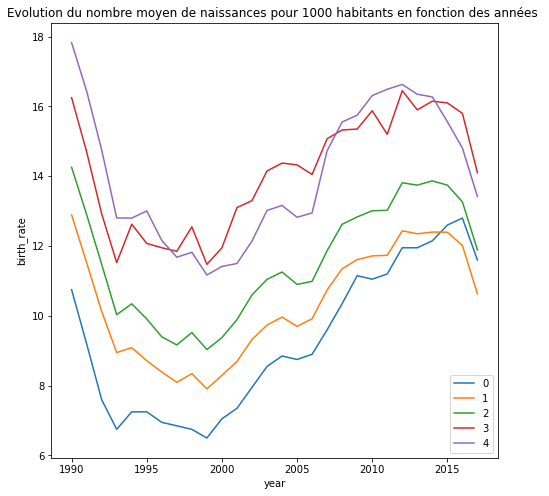

In [19]:
moy_birth_rate.plot(use_index=True,figsize=[8,8],ylabel='birth_rate',legend=True,title='Evolution du nombre moyen de naissances pour 1000 habitants en fonction des années ')

Remarques: 
* On observe que les courbes donnant l'évolution temporelle du nombre moyen de naissance pour 1000 habitants semblent suivre les memes phases d'évolution quelque-soit le type du sujet: décroissance quasi-affine 1990-1994 puis forme de puits de potentiel 1995-2000 puis croissance jusqu'à avoir une forme de sommet de potentiel 2005-2015

### Death Rate

<AxesSubplot:title={'center':'Evolution du nombre moyen de décès pour 1000 habitants en fonction des années '}, xlabel='year', ylabel='death_rate'>

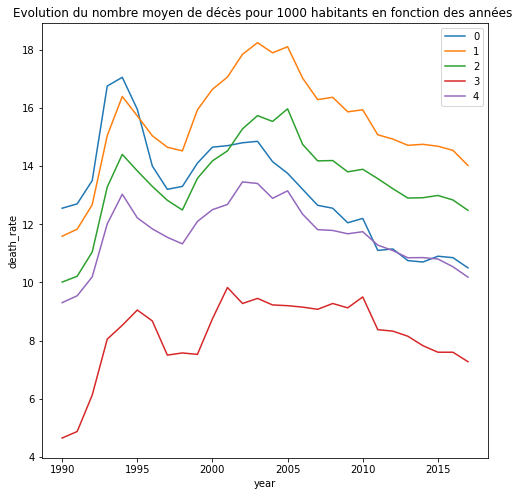

In [20]:
moy_death_rate.plot(use_index=True,figsize=[8,8],ylabel='death_rate',legend=True,title='Evolution du nombre moyen de décès pour 1000 habitants en fonction des années ')

Remarques: 
* Meme observation, les formes des courbes semblent suivre les memes phases

* Le nombre de décès moyen pour 1000 habitants des Okrugs (label=3) est nettement plus inférieur à celui des autres sujets et ce tout au long de la période étudiée

### GDW

<AxesSubplot:title={'center':'Evolution du gdw moyen en fonction des années '}, xlabel='year', ylabel='gdw'>

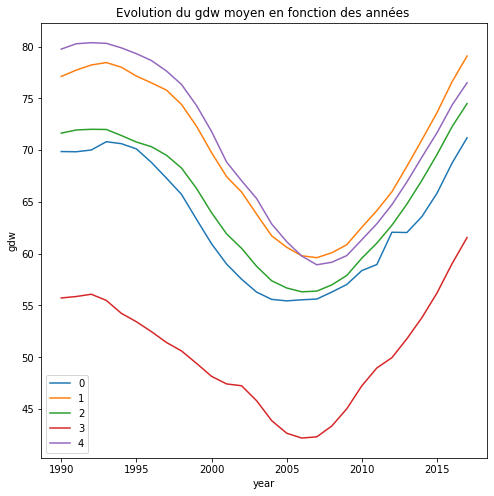

In [21]:
moy_gdw.plot(use_index=True,figsize=[8,8],ylabel='gdw',legend=True,title='Evolution du gdw moyen en fonction des années ')

Remarque
* Meme observation, les formes des courbes semblent suivre les memes phases

* Les Okrugs (label=3) semblent se distinguer du reste des sujets de la Fédération avec une valeur moyenne du poids démographique globale nettement inférieur tout au long de la période étudiée

### Urbanization

<AxesSubplot:title={'center':'Evolution du pourcentage moyen de la population urbaine '}, xlabel='year', ylabel='urbanization'>

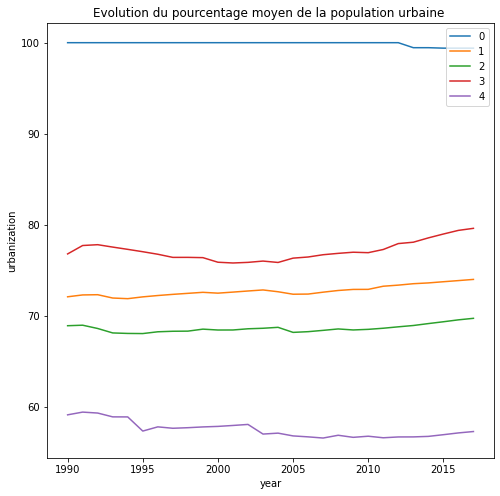

In [22]:
moy_urbanization.plot(use_index=True,figsize=[8,8],ylabel='urbanization',legend=True,title='Evolution du pourcentage moyen de la population urbaine ')

Remarques: 
* Les villes fédérales se distinguent du reste des types de sujets de la Fédération avec un taux de population urbaine moyen supérieur à 95% (nettement supérieur) tout au long de la période étudiée

* Les Républiques quant à elles se caractérisent avec un taux de population urbaine moyen ne dépassant pas 60% et bien inférieur à celui des autres types de sujets tout au long de la période étudiée

### Première synthèse

* Le pourcentage de la population urbaine represente le paramètre démographique pour lequel il y a le plus d'écart visible entre les valeurs moyenne des types de sujet

* Le pourcentage moyen de la population urbaine peuvent (s'ils présentent une faible dispersion) représenter un critère de classification des Républiques

* De meme le taux moyen de décès pour 1000 habitants ainsi que le poids démographique global moyen (s'ils présentent une faible dispersion) représenter un critère de classification des Okrugs

* Le pourcentage de la population urbaine, du fait qu'il n y ait que 2 villes d'importances fédérale et à la vue du graphique précédent semble etre un excellent candidat pour la classification de ce type vérifions cela: 

In [23]:
print('Oblasts :',data1['urbanization'].describe(),'\n')
print('Krais :',data2['urbanization'].describe(),'\n')
print('Okrugs :',data3['urbanization'].describe(),'\n')
print('Républiques :',data4['urbanization'].describe(),'\n')
print('Villes d importance fédarale',data0['urbanization'].values,'\n')

Oblasts : count    1316.000000
mean       72.733746
std         8.378658
min        54.670000
25%        66.597500
50%        71.790000
75%        79.370000
max        95.800000
Name: urbanization, dtype: float64 

Krais : count    252.000000
mean      68.609762
std       10.897504
min       51.970000
25%       55.960000
50%       75.105000
75%       77.370000
max       82.100000
Name: urbanization, dtype: float64 

Okrugs : count    112.000000
mean      77.124732
std       11.090545
min       61.890000
25%       66.380000
50%       76.115000
75%       86.450000
max       92.300000
Name: urbanization, dtype: float64 

Républiques : count    573.000000
mean      57.476736
std       13.389089
min       23.630000
25%       45.980000
50%       59.790000
75%       67.500000
max       82.020000
Name: urbanization, dtype: float64 

Villes d importance fédarale [100.  100.  100.  100.  100.  100.  100.  100.  100.  100.  100.  100.
 100.  100.  100.  100.  100.  100.  100.  100.  100.  100.  1

La valeur minimale du paramètre 'urbanization' de l'ensemble des villes fédérales est supérieure de plus de 4% de la valeur maximale pour le reste des types  

On déduit que le pourcentage de la population urbaine est un critère suffisant pour distinguer les villes fédérales des autres types de sujets, l'analyse de ce type de sujets s'arrete donc sur cette note

## 4.2 Evolution temporelle des paramètres démographiques en fonction du type du sujet - nuage de points

Visualisons cette fois pour chaque type non pas les valeurs moyennes mais bien les valeurs propres (telles qu'elles sont données dans le dataset) en nuages de points pour chaque paramètre démographique

array([<AxesSubplot:xlabel='year'>, <AxesSubplot:xlabel='year'>,
       <AxesSubplot:xlabel='year'>], dtype=object)

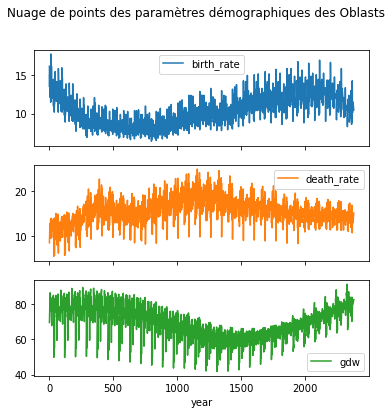

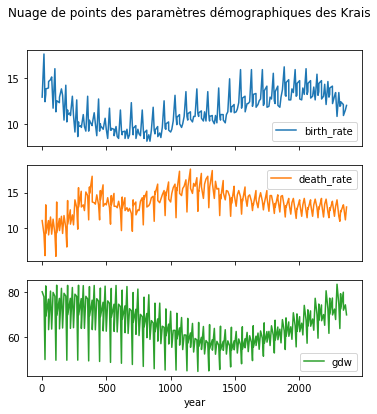

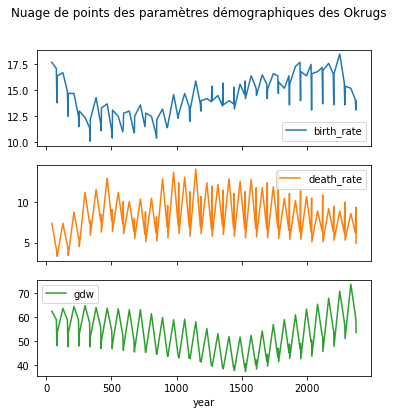

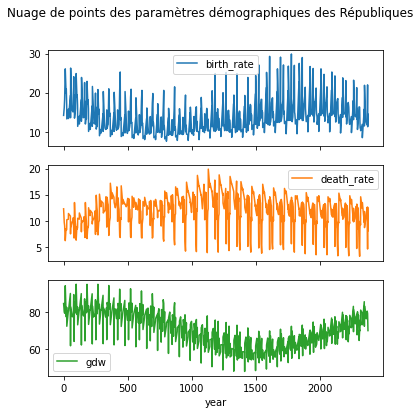

In [24]:
data1.drop(['urbanization','year'],axis=1).plot(use_index=True,figsize=[6,6],legend=True,xlabel='year',title='Nuage de points des paramètres démographiques des Oblasts',subplots=True)
data2.drop(['urbanization','year'],axis=1).plot(use_index=True,figsize=[6,6],legend=True,xlabel='year',title='Nuage de points des paramètres démographiques des Krais',subplots=True)
data3.drop(['urbanization','year'],axis=1).plot(use_index=True,figsize=[6,6],legend=True,xlabel='year',title='Nuage de points des paramètres démographiques des Okrugs',subplots=True)
data4.drop(['urbanization','year'],axis=1).plot(use_index=True,figsize=[6,6],legend=True,xlabel='year',title='Nuage de points des paramètres démographiques des Républiques',subplots=True)

## 4.3 Histogrammes en fréquences des paramètres démographiques

array([<AxesSubplot:ylabel='Frequency'>, <AxesSubplot:ylabel='Frequency'>,
       <AxesSubplot:ylabel='Frequency'>], dtype=object)

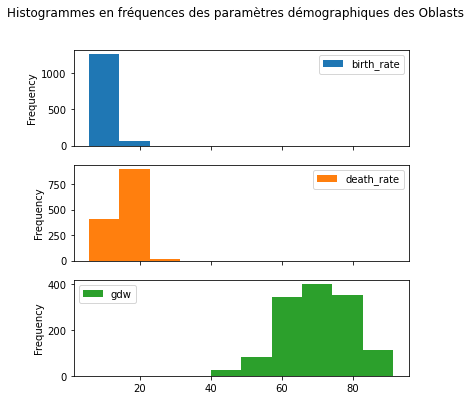

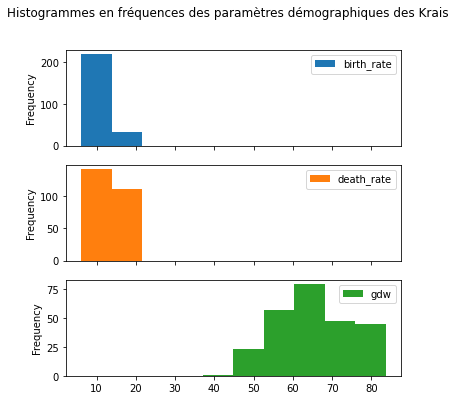

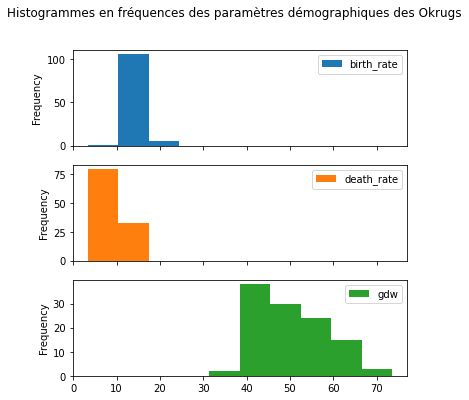

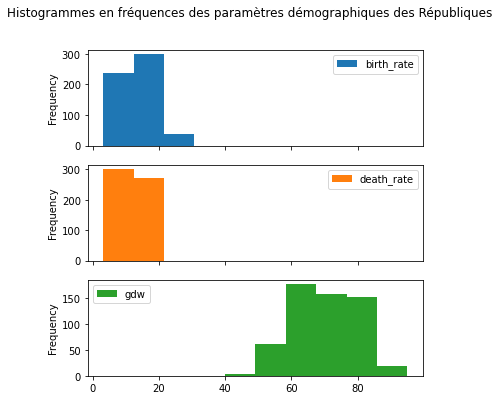

In [25]:
data1.drop(['urbanization','year'],axis=1).plot(use_index=True,figsize=[6,6],legend=True,xlabel='year',title='Histogrammes en fréquences des paramètres démographiques des Oblasts',subplots=True,kind='hist')
data2.drop(['urbanization','year'],axis=1).plot(use_index=True,figsize=[6,6],legend=True,xlabel='year',title='Histogrammes en fréquences des paramètres démographiques des Krais',subplots=True,kind='hist')
data3.drop(['urbanization','year'],axis=1).plot(use_index=True,figsize=[6,6],legend=True,xlabel='year',title='Histogrammes en fréquences des paramètres démographiques des Okrugs',subplots=True,kind='hist')
data4.drop(['urbanization','year'],axis=1).plot(use_index=True,figsize=[6,6],legend=True,xlabel='year',title='Histogrammes en fréquences des paramètres démographiques des Républiques',subplots=True,kind='hist')

 ## 4.4 Analyse des grandeurs statistiques des paramètres démographiques

Nous allons calculer pour chaque paramètre démographique pour chaque type les grandeurs statistiques (calculées sur l'ensemble des années) suivantes: 

* Statistiques générales: nombre de valeurs - moyenne - écart type - min - max - quartiles  

* Matrice de covariance (ensemble des paramètres démographiques)

* Matrice de corrélation affine (corrélation de Pearson)

* Matrice de corrélation de Spearman (corrélation non affine mais monotone)

### Statistiques générales

In [26]:
print('Oblasts',data1.drop(['year'],axis=1).describe(),'\n')
print('Krais',data2.drop(['year'],axis=1).describe(),'\n')
print('Okrugs',data3.drop(['year'],axis=1).describe(),'\n')
print('Républiques',data4.drop(['year'],axis=1).describe(),'\n')

Oblasts         birth_rate   death_rate          gdw  urbanization
count  1316.000000  1316.000000  1316.000000   1316.000000
mean     10.322948    15.476064    69.883495     72.733746
std       2.030023     2.853457     9.358344      8.378658
min       6.400000     5.600000    41.750000     54.670000
25%       8.700000    13.700000    63.330000     66.597500
50%      10.200000    15.400000    69.885000     71.790000
75%      11.600000    17.200000    77.305000     79.370000
max      17.800000    24.900000    91.340000     95.800000 

Krais        birth_rate  death_rate         gdw  urbanization
count  252.000000  252.000000  252.000000    252.000000
mean    11.563492   13.495635   65.090992     68.609762
std      1.967469    1.937145    9.758430     10.897504
min      8.100000    6.100000   44.630000     51.970000
25%      9.975000   12.500000   58.270000     55.960000
50%     11.350000   13.550000   64.140000     75.105000
75%     13.000000   14.700000   72.432500     77.370000
max  

Remarques:
* L'écart-type du paramètre 'urbanization' est de l'ordre de 23% de la valeur moyenne pour les républiques, en addition en comparant les quartiles de ce paramètre pour les 4 types de sujets (qui ne s'éxcluent pas mutuellement et se chevauchent), on déduit que ce paramètre à lui seul ne suffit pas pour une caractériser totalement ce type les républiques
* L'écart-type du paramètre 'gdw' est de l'ordre de 16% de la valeur moyenne pour les Okrugs, en comparant les quartiles de ce paramètre pour les 4 autres types de sujets ce paramètre consitue un bon candidat pour caractériser ce type de sujet
* En suivant la meme analyse, le paramètre 'death_rate' consitue également un bon candidat pour caractériser les Okrugs

### Matrices de covariance

#### Visualisation en heatmaps

Oblasts


<AxesSubplot:>

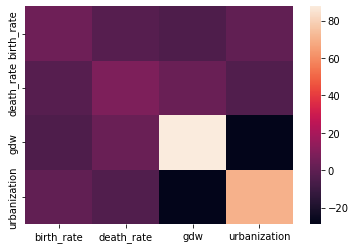

In [27]:
print('Oblasts')
sns.heatmap(data1.drop(['year'],axis=1).cov(ddof=1))

Krais


<AxesSubplot:>

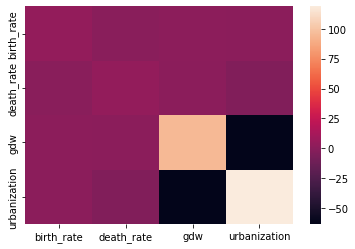

In [28]:
print('Krais')
sns.heatmap(data2.drop(['year'],axis=1).cov(ddof=1))

Okrugs


<AxesSubplot:>

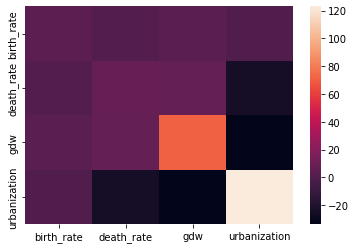

In [29]:
print('Okrugs')
sns.heatmap(data3.drop(['year'],axis=1).cov(ddof=1))

Républiques


<AxesSubplot:>

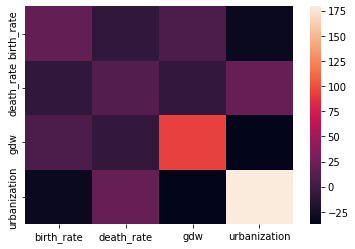

In [30]:
print('Républiques')
sns.heatmap(data4.drop(['year'],axis=1).cov(ddof=1))

#### Affichage des valeurs

In [31]:
print('Oblasts',data1.drop(['year'],axis=1).cov(ddof=1),'\n')
print('Krais',data2.drop(['year'],axis=1).cov(ddof=1),'\n')
print('Okrugs',data3.drop(['year'],axis=1).cov(ddof=1),'\n')
print('Républiques',data4.drop(['year'],axis=1).cov(ddof=1),'\n')

Oblasts               birth_rate  death_rate        gdw  urbanization
birth_rate      4.120994   -2.810386  -4.901743      0.553017
death_rate     -2.810386    8.142217   2.969888     -4.190554
gdw            -4.901743    2.969888  87.578611    -28.731364
urbanization    0.553017   -4.190554 -28.731364     70.201905 

Krais               birth_rate  death_rate        gdw  urbanization
birth_rate      3.870933   -0.686415   0.746574      0.116489
death_rate     -0.686415    3.752531   0.686235     -4.043901
gdw             0.746574    0.686235  95.226960    -63.319363
urbanization    0.116489   -4.043901 -63.319363    118.755602 

Okrugs               birth_rate  death_rate        gdw  urbanization
birth_rate      3.849073    0.213855   3.404228     -0.468715
death_rate      0.213855    7.854051   6.918362    -24.559892
gdw             3.404228    6.918362  70.568696    -33.453526
urbanization   -0.468715  -24.559892 -33.453526    123.000182 

Républiques               birth_rate  death

-Remarques Oblasts:
* Covariance 'birth_rate'-'death_rate' de l'ordre de -1/10 du produit des variances respectives
* Covariances des autres paramètres 2 à 2 négligeables devant le produit des variances respectives

-Remarques Krais:
* Covariances des autres paramètres 2 à 2 négligeables devant le produit des variances respectives
* Covariance du couple 'gdw'-'urbanization' 2 fois supérieur aux valeurs des autres types de sujet

-Remarques Okrugs:
* Covariances des paramètres 2 à 2 négligeables devant le produit des variances respectives
* Plus grande covariance en valeur absolue (valeur négative) pour le couple 'death_rate'-'urbanization' qui est de l'ordre de -24.56

-Remarques Républiques:
* Covariances des paramètres 2 à 2 négligeables devant le produit des variances respectives
* Plus grande covariance en valeur absolue pour les couple 'birth_rate'-'death_rate', 'birth_rate'-'gdw', 'birth_rate'-'urbanization', 'death_rate'-'gdw'
* Covariance du couple 'death_rate'-'urbanization' de l'ordre de 20


### Matrices de corrélation

#### Visualisation en heatmaps des coefficients de corrélation linéaire

Oblasts 
 AxesSubplot(0.125,0.125;0.62x0.755) 



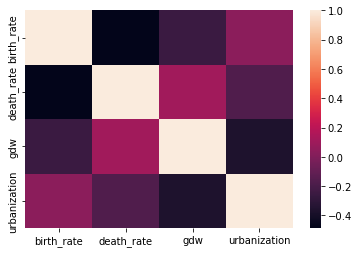

In [32]:
print('Oblasts \n',sns.heatmap(data1.drop(['year'],axis=1).corr(method='pearson', min_periods=1)),'\n')

Krais 
 AxesSubplot(0.125,0.125;0.62x0.755) 



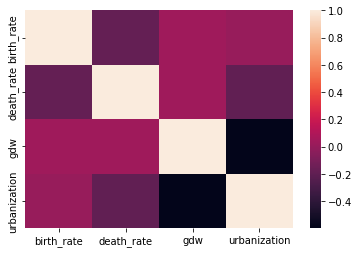

In [33]:
print('Krais \n',sns.heatmap(data2.drop(['year'],axis=1).corr(method='pearson', min_periods=1)),'\n')

Okrugs 
 AxesSubplot(0.125,0.125;0.62x0.755) 



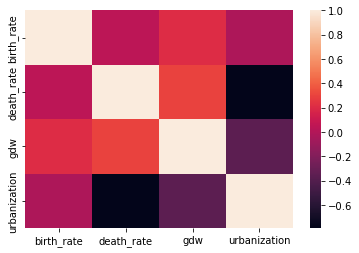

In [34]:
print('Okrugs \n',sns.heatmap(data3.drop(['year'],axis=1).corr(method='pearson', min_periods=1)),'\n')

Républiques 
 AxesSubplot(0.125,0.125;0.62x0.755) 



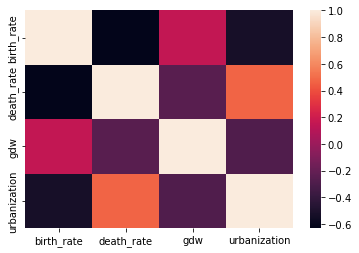

In [35]:
print('Républiques \n',sns.heatmap(data4.drop(['year'],axis=1).corr(method='pearson', min_periods=1)),'\n')

#### Affichage des valeurs

In [36]:
#Corrélation de Pearson
print('Oblasts',data1.drop(['year'],axis=1).corr(method='pearson', min_periods=1),'\n')
print('Oblasts',data2.drop(['year'],axis=1).corr(method='pearson', min_periods=1),'\n')
print('Oblasts',data3.drop(['year'],axis=1).corr(method='pearson', min_periods=1),'\n')
print('Oblasts',data4.drop(['year'],axis=1).corr(method='pearson', min_periods=1),'\n')

Oblasts               birth_rate  death_rate       gdw  urbanization
birth_rate      1.000000   -0.485170 -0.258018      0.032513
death_rate     -0.485170    1.000000  0.111217     -0.175277
gdw            -0.258018    0.111217  1.000000     -0.366423
urbanization    0.032513   -0.175277 -0.366423      1.000000 

Oblasts               birth_rate  death_rate       gdw  urbanization
birth_rate      1.000000   -0.180101  0.038885      0.005433
death_rate     -0.180101    1.000000  0.036302     -0.191563
gdw             0.038885    0.036302  1.000000     -0.595428
urbanization    0.005433   -0.191563 -0.595428      1.000000 

Oblasts               birth_rate  death_rate       gdw  urbanization
birth_rate      1.000000    0.038895  0.206554     -0.021542
death_rate      0.038895    1.000000  0.293867     -0.790181
gdw             0.206554    0.293867  1.000000     -0.359073
urbanization   -0.021542   -0.790181 -0.359073      1.000000 

Oblasts               birth_rate  death_rate       gdw 

In [37]:
#Corrélation de Pearson
print('Oblasts',data1.drop(['year'],axis=1).corr(method='spearman', min_periods=1),'\n')
print('Krais',data2.drop(['year'],axis=1).corr(method='spearman', min_periods=1),'\n')
print('Okrugs',data3.drop(['year'],axis=1).corr(method='spearman', min_periods=1),'\n')
print('Républiques',data4.drop(['year'],axis=1).corr(method='spearman', min_periods=1),'\n')

Oblasts               birth_rate  death_rate       gdw  urbanization
birth_rate      1.000000   -0.481029 -0.291675      0.058128
death_rate     -0.481029    1.000000  0.050555     -0.137816
gdw            -0.291675    0.050555  1.000000     -0.280545
urbanization    0.058128   -0.137816 -0.280545      1.000000 

Krais               birth_rate  death_rate       gdw  urbanization
birth_rate      1.000000   -0.183815  0.027652     -0.001183
death_rate     -0.183815    1.000000 -0.050585     -0.267943
gdw             0.027652   -0.050585  1.000000     -0.616105
urbanization   -0.001183   -0.267943 -0.616105      1.000000 

Okrugs               birth_rate  death_rate       gdw  urbanization
birth_rate      1.000000    0.019484  0.138107     -0.007817
death_rate      0.019484    1.000000  0.286232     -0.713986
gdw             0.138107    0.286232  1.000000     -0.319100
urbanization   -0.007817   -0.713986 -0.319100      1.000000 

Républiques               birth_rate  death_rate       gdw

On classe les types de sujet par ordre décroissant des valeurs des coefficiens en valeur absolue:

Coefficient de Spearman qu'on note $\rho_i$ avec $i$ le label du type

|Couples\classement|$1$|$2$|$3$|$4$|
|:-:|:-:|:-:|:-:|:-:|
|'birth_rate'-'death_rate'|$\vert \rho_4 \vert   =0.63$|$ \vert \rho_1 \vert =0.48$|$ \vert \rho_2 \vert =0.18$|$ \vert \rho_3 \vert =0.02$|
|'birth_rate'-'gdw'|$ \vert \rho_1 \vert =0.29$|$ \vert \rho_3 \vert =0.14$|$ \vert \rho_4 \vert =0.008$|$ \vert \rho_2 \vert =0.003$|
|'birth_rate'-'urbanization'|$ \vert \rho_4 \vert =0.485$|$ \vert \rho_1 \vert =0.058$|$ \vert \rho_3 \vert =0.007$|$ \vert \rho_2 \vert =0.001$|
|'death_rate'-'gdw'|$ \vert \rho_3 \vert =0.28623$|$ \vert \rho_4 \vert =0.26491$|$ \vert \rho_4 \vert =0.05059$|$ \vert \rho_2 \vert =0.05056$|
|'death_rate'-'urbanization'|$ \vert \rho_3 \vert =0.71$|$ \vert \rho_4 \vert =0.43$|$ \vert \rho_2 \vert =0.27$|$ \vert \rho_1 \vert =0.14$|
|'gdw'-'urbanization'|$ \vert \rho_2 \vert =0.62$|$ \vert \rho_3 \vert =0.32$|$ \vert \rho_1 \vert =0.28$|$ \vert \rho_4 \vert =0.27$|

On retouve le meme classement avec quasiment les memes valeurs en calculant le coefficient de corrélation linéaire (coeff de corrélation de Pearson)

Remarques:
* Forte corrélation du couple 'birth_rate'-'death_rate' pour les Républiques $\; \; \; (\rho_4=-0.63)$ et les Oblasts     ($\rho_1\approx-0.5$)
* Forte corrélation du couple 'death_rate'-'urbanization' pour les Okrugs ($\rho_3=-0.71$) 
* Forte corrélation du couple 'gdw'-'urbanization' pour les Krais ($\rho_2=-0.62$)
* Faibles corrélation des autres couples pour les autres types de sujets ($\vert \rho \vert < 0.5$)

----------------------

# 5. Synthèse et conclusion

## 5.1 Synthèse finale 

Après analyse de nos données sous 2 aspects; en considérant d'abord les valeurs moyennes sur chaque année des paramètres démographiques de chaque type puis en considérant les caractéristiques statistiques de l'ensemble des valeurs propres non moyennées pour chaque type de sujet. Nous avons en résumé:

* Le paramètre 'urbanization' (pourcentage de la population urbaine) suffit à caractériser le type 'Villes d'importance fédérale'

* Les Krais présentent la plus forte corrélation (de Pearson et de Spearman) entre les paramètres 'gdw' et 'urbanization' 

* Les Okrugs présentent quand à eux la plus forte corrélation (de Pearson et de Spearman) entre les paramètres 'death_rate' et 'urbanization' en plus d'avoir des valeurs moyennes des paramètres 'gdw' et un 'death_rate' nettement inférieurs en comparaison aux autres types de sujets

* Les Républiques en finalité une forte (et la plus forte) corrélation entre les paramètres 'birth_rate' et 'death_rate'

## 5.2 Conclusion

L'interet de ce Dataset réside en le pré-traitement et le nettoyage à réaliser an amont de l'analyse d'une part:
* Localisation des données manquantes, indentification du noms des régions concernées et des périodes sur lesquelles s'étend le manque de données puis filtrage et sélection
* Etiquettage des régions en fonction du type du sujet
* Segmentisation du dataset en autres dataset selon la direction et les besoins de l'analyse

Puis en le repérage de paramètres pertinents de caractérisation et la ré-évaluation de leurs pertinences aux étapes suivantes de l'analyse. 
